In [1]:
import cv2
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [28]:
im = Image.open("vamp.png")
water = Image.open("water.png")
im1 = im.filter(ImageFilter.GaussianBlur(radius=10))
# plt.figure()
# plt.imshow(im)
# plt.figure()
# plt.imshow(im1)

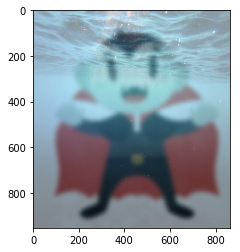

In [29]:
blended = Image.blend(im1, water, 0.5)
plt.figure()
plt.imshow(blended)

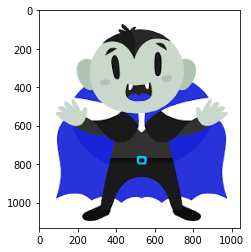

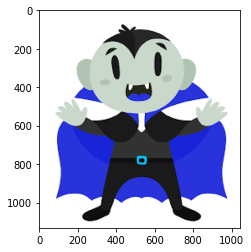

In [4]:
src = cv2.imread('Vamp.png', cv2.IMREAD_UNCHANGED)
dst = cv2.GaussianBlur(src, (5, 5), 0)
plt.figure()
plt.imshow(src)
plt.figure()
plt.imshow(dst)